Source:
    1. https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
    2. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv('../openweather-denpasar/openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=True, index_col='dt_iso', usecols=usecols)
df['date'] = df.index
df = df[['date', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264924 entries, 1990-01-01 00:00:00 to 2020-01-07 23:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 264924 non-null  datetime64[ns]
 1   temp                 264924 non-null  float64       
 2   temp_min             264924 non-null  float64       
 3   temp_max             264924 non-null  float64       
 4   pressure             264924 non-null  float64       
 5   humidity             264924 non-null  int64         
 6   wind_speed           264924 non-null  float64       
 7   wind_deg             264924 non-null  int64         
 8   clouds_all           264924 non-null  int64         
 9   weather_main         264924 non-null  object        
 10  weather_description  264924 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 24.3+ MB


In [3]:
df.head()

,date,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
dt_iso,,,,,,,,,,,
1990-01-01 00:00:00,1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1990-01-01 01:00:00,1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
1990-01-01 02:00:00,1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
1990-01-01 03:00:00,1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
1990-01-01 04:00:00,1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [4]:
df_temp = df[['temp']]
df_temp.head()

,temp
dt_iso,
1990-01-01 00:00:00,25.82
1990-01-01 01:00:00,26.20
1990-01-01 02:00:00,26.45
1990-01-01 03:00:00,26.80
1990-01-01 04:00:00,27.04


### 1. Introduction to Stationarity

‘Stationarity’ is one of the most important concepts you will come across when working with time series data. **A stationary series is one in which the properties – mean, variance and covariance, do not vary with time**.

<Figure size 1080x432 with 0 Axes>

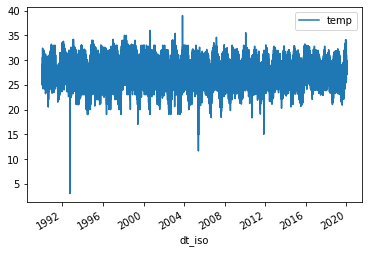

In [5]:
# Check for stationarity
plt.figure(1, figsize=(15,6))
df_temp.plot() # plot hourly data for 20 years

In [6]:
# Function to resampling time series data
def data_resample(data, time):
    """
    data: Dataframe
    time: Resampling frequencies
    """
    if time == 'hourly':
        df_resample = data.resample('H').mean() # hour
    elif time == 'daily':
        df_resample = data.resample('D').mean() # day
    elif time == 'weekly':
        df_resample = data.resample('W').mean() # week
    elif time == 'monthly':
        df_resample = data.resample('M').mean() # month
    elif time == 'quarterly':
        df_resample = data.resample('Q').mean() # quarter
    elif time == 'yearly':
        df_resample = data.resample('A').mean() # year
    
    return df_resample

### 1.1 Check the data stationarity visualy

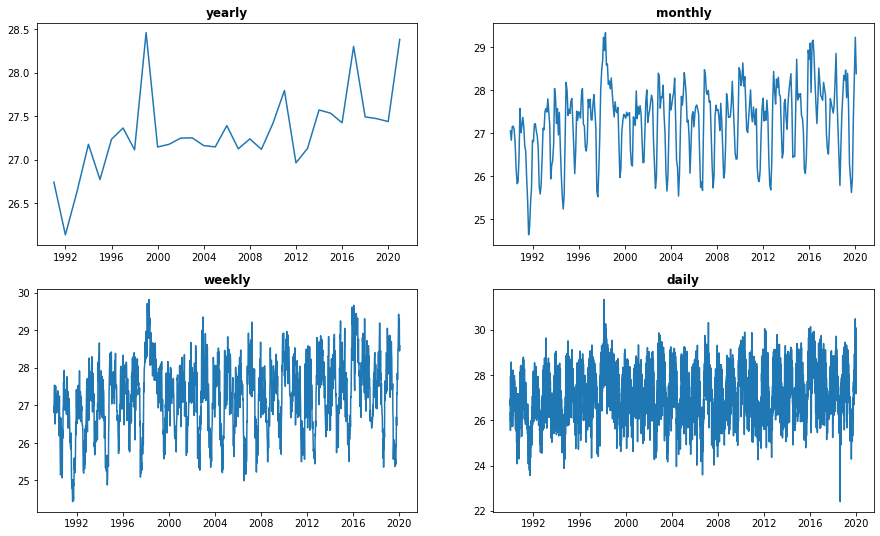

In [7]:
index = 0
resample_time = ['yearly', 'monthly', 'weekly', 'daily']
plt.figure(1, figsize=(15,9))
for subplot in range(221, 225):
    plt.subplot(subplot)
    dt = data_resample(df['temp'], resample_time[index])
    plt.plot(dt)
    plt.title(resample_time[index], fontweight='bold')
    index = index + 1
    
plt.show()

In [8]:

df_temp = data_resample(df_temp.loc['1990':'2019'], 'daily')
df_temp.head()

,temp
dt_iso,
1990-01-01,26.333750
1990-01-02,25.559583
1990-01-03,26.956667
1990-01-04,26.638750
1990-01-05,27.940417


From the above figure, we can determined that the daily temperature data is more stationary than the other chart.

### 1.2 Check the data stationarity statistically

There are many methods to determined the stationarity of time series data. In this part we only used several of them.

**1. ADF (Augmented Dickey Fuller) Test**

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)
    
# Apply ADF Test
adf_test(df_temp)

Results of Dickey-Fuller Test:
Test Statistic                -7.690957e+00
p-value                        1.419739e-11
#Lags Used                     3.800000e+01
Number of Observations Used    1.091800e+04
Critical Value (1%)           -3.430949e+00
Critical Value (5%)           -2.861805e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


**Test for stationarity**: If the `Test Statistic` is less than the `Critical Value`, we can reject the null hypothesis (aka the **series is stationary**). When the `Test Statistic` is greater than the `Critical value`, we fail to reject the null hypothesis (which means the **series is not stationary**).

**2. KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test**

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series. We will understand the trend stationarity in detail in the next section. For now, let’s focus on the implementation and see the results of the KPSS test.

**Null Hypothesis**: The process is trend stationary.

**Alternate Hypothesis**: The series has a unit root (series is not stationary).

In [10]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpss_test = kpss(timeseries, regression='c', nlags='legacy') # nlags = 'auto' or 'legacy'
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic', 'p-value', 'Lag Used'])
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value
        
    print(kpss_output)
    
# Apply KPSS Test
kpss_test(df_temp)

Results of KPSS Test:
Test Statistic            1.864364
p-value                   0.010000
Lag Used                 39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\rudyh\documents\tensorflow-python\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


**Test for stationarity**: If the `Test Statistic` is greater than the `Critical value`, we reject the null hypothesis (**series is not stationary**). If the `Test Statistic` is less than the `Critical value`, if fail to reject the null hypothesis (**series is stationary**).

The tests showed contradictory results. One of the tests showed that the series is stationary while the other showed that the series is not. As it turns out, there are more than one type of stationarity.

**3. Types of Stationarity**
Let us understand the different types of stationarities and how to interpret the results of the above tests.

 - **Strict Stationary**: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.
 - **Trend Stationary**: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
 - **Difference Stationary**: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.
 - **Case 1**: Both tests conclude that the series is not stationary -> series is not stationary
 - **Case 2**: Both tests conclude that the series is stationary -> series is stationary
 - **Case 3**: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
 - **Case 4**: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

If we used hourly data, Case 4 is more suitable.

**4. Making a Time Series Stationary**

**Differencing**
This method computer the difference of consecutive terms in the series. Differencing is typically perfomed to get rid of the varying mean.

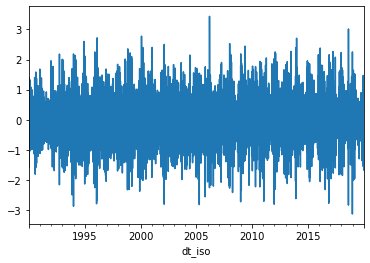

In [14]:
df_diff = df_temp['temp'] - df_temp['temp'].shift(1)
df_temp['diff'] = df_diff
df_temp['diff'].dropna().plot()

**Seasonal Differencing**
In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation on a Monday will be subtracted from an observation taken on the previous Monday.

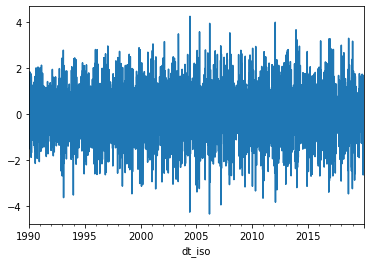

In [12]:
n = 7 # Weekly
df_temp['s_diff'] = df_temp['temp'] - df_temp['temp'].shift(n)
df_temp['s_diff'].plot()

**Transformation**
Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform.

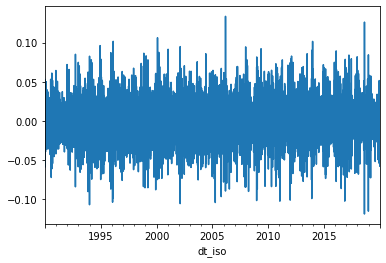

In [13]:
df_temp['temp_log'] = np.log(df_temp['temp'])
df_temp['temp_log_diff'] = df_temp['temp_log'] - df_temp['temp_log'].shift(1)
df_temp['temp_log_diff'].dropna().plot()

In [21]:
def test_stationarity(timeseries, info):
    """
    timeseries: pandas time series
    info: resampling information, (hourly, daily, weekly, monthly, quarterly, yearly)
    """
    
    # Determining rolling statistics
    windowsize = 24
    rolmean = timeseries.rolling(windowsize).mean()
    rolstd = timeseries.rolling(windowsize).mean()
    
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='yellow', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation ' + info)
    plt.show(block=False)
    
    # Perform Dickey-Fuller Test:
    adf_test(timeseries)
    
    print('\n')
    
    # Perform KPSS Test:
    kpss_test(timeseries)

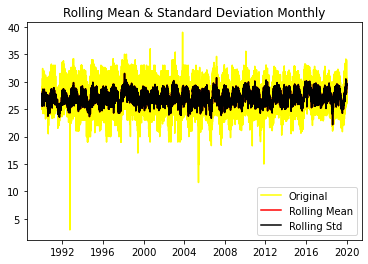

Results of Dickey-Fuller Test:
Test Statistic                    -22.328211
p-value                             0.000000
#Lags Used                         86.000000
Number of Observations Used    262881.000000
Critical Value (1%)                -3.430375
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64


Results of KPSS Test:
Test Statistic           15.024769
p-value                   0.010000
Lag Used                 86.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\rudyh\documents\tensorflow-python\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [22]:
df_temp = data_resample(df.loc['1990':'2019']['temp'], 'hourly')
test_stationarity(df_temp, 'Monthly')

### Estimating & Eliminating Trend

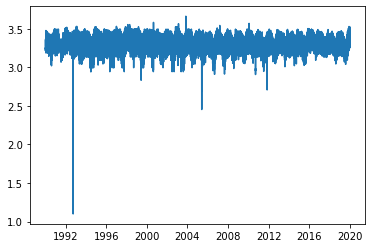

In [23]:
df_temp_log = np.log(df_temp)
plt.plot(df_temp_log)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

1. **Aggregation** – taking average for a time period like monthly/weekly averages
2. **Smoothing** – taking rolling averages
3. **Polynomial Fitting** – fit a regression model

In this part, only **Smoothing** is present. There are various ways of smoothing, but only two of them are shown below.

**Moving Average**

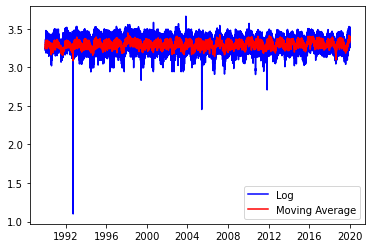

In [25]:
moving_avg = df_temp_log.rolling(24).mean()
plt.plot(df_temp_log, color='blue', label='Log')
plt.plot(moving_avg, color='red', label='Moving Average')
plt.legend()

In [26]:
df_temp_log_ma_diff = df_temp_log - moving_avg
df_temp_log_ma_diff.head(20)

dt_iso
1990-01-01 00:00:00   NaN
1990-01-01 01:00:00   NaN
1990-01-01 02:00:00   NaN
1990-01-01 03:00:00   NaN
1990-01-01 04:00:00   NaN
1990-01-01 05:00:00   NaN
1990-01-01 06:00:00   NaN
1990-01-01 07:00:00   NaN
1990-01-01 08:00:00   NaN
1990-01-01 09:00:00   NaN
1990-01-01 10:00:00   NaN
1990-01-01 11:00:00   NaN
1990-01-01 12:00:00   NaN
1990-01-01 13:00:00   NaN
1990-01-01 14:00:00   NaN
1990-01-01 15:00:00   NaN
1990-01-01 16:00:00   NaN
1990-01-01 17:00:00   NaN
1990-01-01 18:00:00   NaN
1990-01-01 19:00:00   NaN
Freq: H, Name: temp, dtype: float64

In [1]:
# df_temp_log_ma_diff.dropna(inplace=True)
# test_stationarity(df_temp_log_ma_diff, 'hourly')

In [ ]:
expweighted_avg = df_temp_log.ewm(span=12).mean()
plt.plot(df_temp_log)
plt.plot(expweighted_avg, color='red')

In [ ]:
df_temp_log_ewm_diff = df_temp_log - expweighted_avg
test_stationarity(df_temp_log_ewm_diff, 'daily')

### Principal Component Analysis

Source: https://medium.com/@ansjin/dimensionality-reduction-using-pca-on-multivariate-timeseries-data-b5cc07238dc4

Principal Component Analysis (PCA) is one of the most popular dimensionality reduction methods which transforms the data by projecting it to a set of orthogonal axes. It works by finding the eigenvectors and eigenvalues of the covariance matrix of the dataset. The Eigenvectors are called as the “Principal Components” of the dataset.

In [4]:
df.head()

,date,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
dt_iso,,,,,,,,,,,
1990-01-01 00:00:00,1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1990-01-01 01:00:00,1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
1990-01-01 02:00:00,1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
1990-01-01 03:00:00,1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
1990-01-01 04:00:00,1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [10]:
# Drop the categorical feature
df_pca = df.drop(['date','weather_main', 'weather_description'], axis=1)
df_pca.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
dt_iso,,,,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Standarizing the data**

In [32]:
X = df_pca.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print some of it
print(X_scaled[:3])

[[-0.74052778 -0.67299397 -0.79303448 -0.01439658  0.59116378 -1.17952505
   0.78582811  2.38751689]
 [-0.54690386 -0.48041482 -0.60199982  0.42293844  0.36180842 -0.79724138
   1.04465198  2.10673184]
 [-0.4195197  -0.35371801 -0.47631912  0.42293844  0.36180842 -0.61395469
   1.22112279  2.22706829]]


Currently, we will apply PCA without passing any parameters for the initialization of the object which means all the components are kept.

In [33]:
pca = PCA()
X_pca = pca.fit(X_scaled)

**Determined the number of components**:

An important part of using PCA is to estimate how many components are needed to describe the data.
1. You can get the eigenvectors using `pca.components_`
2. eigenvalues using `pca.explained_variance_`
3. Percentage of variance explained by each of the selected components using `pca.explained_variance_ratio_`

The number of components needed can be determined by looking at the cumulative **_explained variance ratio_** as a function of the number of components as shown in the below graph.

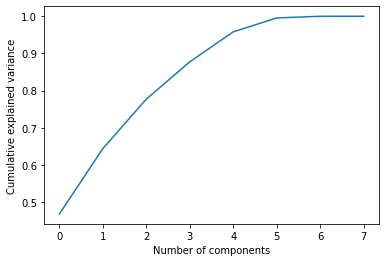

In [34]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

This curve quantifies how much of the total, the 7-dimensional variance is contained within the first N components. For example, we see that the first two components contain approximately 75% of the variance, while we need 5 components to describe close to 100% of the variance. Which means we can reduce our data dimension to 5 from 8 without much loss of the data.

**Dimentionality Reduction**

Now we need 5 components only, so we can apply PCA with 5 components to get the reduced dataset.

In [35]:
num_components = 5
pca = PCA(num_components)
X_pca = pca.fit_transform(X_scaled)

_(Optional)_ One can do the apply PCA to dimentionality reduction together by specifying `n_components = 0.99` parameter. PCA will select the number of components such that the amount of variance that needs to be explained is greater than the precentage specified by `n_components`.

In [36]:
# pca = PCA(n_components=0.99)
# X_pca = pca.fit_transform(X_scaled)
# print(pca.n_components)

In [37]:
pd.DataFrame(pca.components_, columns=df_pca.columns)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
0,-0.507345,-0.502096,-0.503650,0.187042,0.408323,-0.124532,-0.068330,0.122259
1,0.002842,0.002606,0.001751,-0.565884,0.247477,0.029693,0.639619,0.456639
2,-0.076255,-0.075877,-0.074974,0.293969,-0.239742,0.851796,0.080811,0.326842
3,-0.116418,-0.119806,-0.112482,-0.162352,0.051973,0.314465,0.405913,-0.816534
4,-0.028932,-0.035690,-0.022840,-0.650304,0.197339,0.345825,-0.644104,-0.032642


In [38]:
# Automating the process of extracting important features
n_pcs = pca.n_components

most_important = [np.abs(pca.components_[i].argmax()) for i in range(n_pcs)]

initial_feature_names = df_pca.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print(most_important_names)

['humidity', 'wind_deg', 'wind_speed', 'wind_deg', 'wind_speed']


c:\users\rudyh\documents\python_code\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


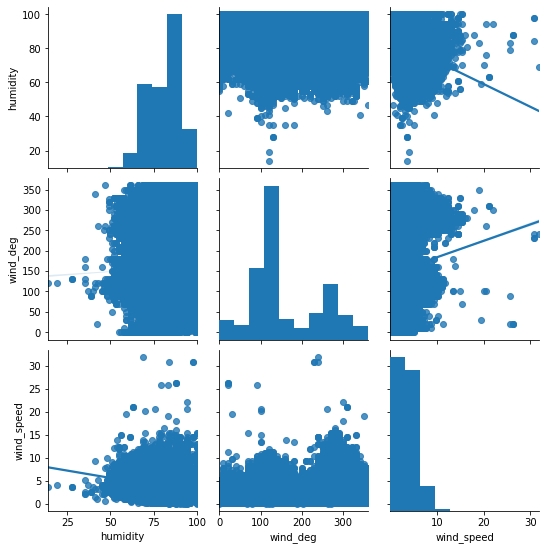

In [47]:
df_pair_plot = df_pca[['humidity', 'wind_deg', 'wind_speed']]
sns.pairplot(df_pair_plot, kind='reg')
plt.show()